In [1]:
import collections
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import vae_lib.utils.nn_logger as log
from vae_lib.nn.simple_nn import SimpleNN
from vae_lib.nn.stochastic_nn_with_gmm import StochasticNNWithGmm
from vae_lib.graphics.plot_utils import plot_2d_latent_space
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.utils.static_gmm_on_circle import StaticGmmOnCircle
from vae_lib.preprocessing.load_reuters import load_reuters



from vae_lib.nn.dense_layer import DenseLayer
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle

Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

In [2]:
base_path = "/Users/mjankowski/doc/data/reuters/for_python/"

In [3]:
reuters_data_train_perm, reuters_data_test, reuters_labels_train_one_hot_perm, reuters_labels_test_one_hot, onehot_encoder = load_reuters(base_path=base_path, n_classes=3)
reuters_data_train_perm.shape, reuters_data_test.shape, reuters_labels_train_one_hot_perm.shape, reuters_labels_test_one_hot.shape
    

((1655, 2000), (1102, 2000), (1655, 3), (1102, 3))

In [4]:
tf.reset_default_graph()
log_folder = log.get_log_folder()
print("Writing logs to: {}".format(log_folder))
simple_nn = SimpleNN([2000, 512, 256, 3], learning_rate=1e-3, log_folder=log_folder)
simple_nn.fit(
    reuters_data_train_perm, 
    reuters_labels_train_one_hot_perm, 
    reuters_data_test, 
    reuters_labels_test_one_hot, 
    epochs=10, 
    log_interval=10
)

Writing logs to: /tmp/class_vae/deep/03_05_2019/20190503110601
Train accuracy: 96.01%
Test accuracy: 84.85%
Train accuracy: 99.27%
Test accuracy: 86.3%
Train accuracy: 99.88%
Test accuracy: 87.21%
Train accuracy: 99.88%
Test accuracy: 87.02%
Train accuracy: 99.94%
Test accuracy: 87.11%
Train accuracy: 99.88%
Test accuracy: 86.84%
Train accuracy: 99.94%
Test accuracy: 87.48%
Train accuracy: 99.88%
Test accuracy: 87.21%
Train accuracy: 99.94%
Test accuracy: 87.66%
Train accuracy: 99.94%
Test accuracy: 87.75%


In [10]:
#tf.reset_default_graph()
log_folder = log.get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))

K=3
init_cov = np.array([
    [0.07,0.0],
    [0.0,0.007]
], dtype="float64")
betas = np.ones(K)/K


model_supervised = StochasticNNWithGmm(
    x_dim=reuters_data_train_perm.shape[1],
    y_dim=reuters_labels_train_one_hot_perm.shape[1],
    hidden_dims=[1024, 512, 256, 128, 2],
    log_folder=log_folder,
    alpha=0,
    beta=0,#0.1,
    gamma=1,
    omega=0.0001,
    r=0.8,
    K=K,
    init_cov=init_cov,
    mixture_weights=betas
)
model_supervised.fit(
    X_train=reuters_data_train_perm, 
    y_train=reuters_labels_train_one_hot_perm, 
    X_test=reuters_data_test,
    y_test=reuters_labels_test_one_hot,
    epochs=10,
    log_interval=10
)

test_acc = model_supervised.calculate_accuracy(X=reuters_data_test, y=reuters_labels_test_one_hot)
print("Test accuracy {}".format(test_acc))

Starting autoencoder. Log folder=/tmp/class_vae/deep/01_05_2019/20190501150414
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.7196374535560608
Test accuracy 0.6660616993904114
epoch: 1
Train accuracy 0.9782477617263794
Test accuracy 0.8411978483200073
epoch: 2
Train accuracy 0.9848942756652832
Test accuracy 0.807622492313385
epoch: 3
Train accuracy 0.9963746070861816
Test accuracy 0.8720508217811584
epoch: 4
Train accuracy 0.998791515827179
Test accuracy 0.8448275923728943
epoch: 5
Train accuracy 0.9993957877159119
Test accuracy 0.8656987547874451
epoch: 6
Train accuracy 0.9993957877159119
Test accuracy 0.8593466281890869
epoch: 7
Train accuracy 0.9981873035430908
Test accuracy 0.8067150712013245
epoch: 8
Train accuracy 0.998791515827179
Test accuracy 0.8656987547874451
epoch: 9
Train accuracy 0.998791515827179
Test accuracy 0.8702359199523926
Test accuracy 0.8647912740707397


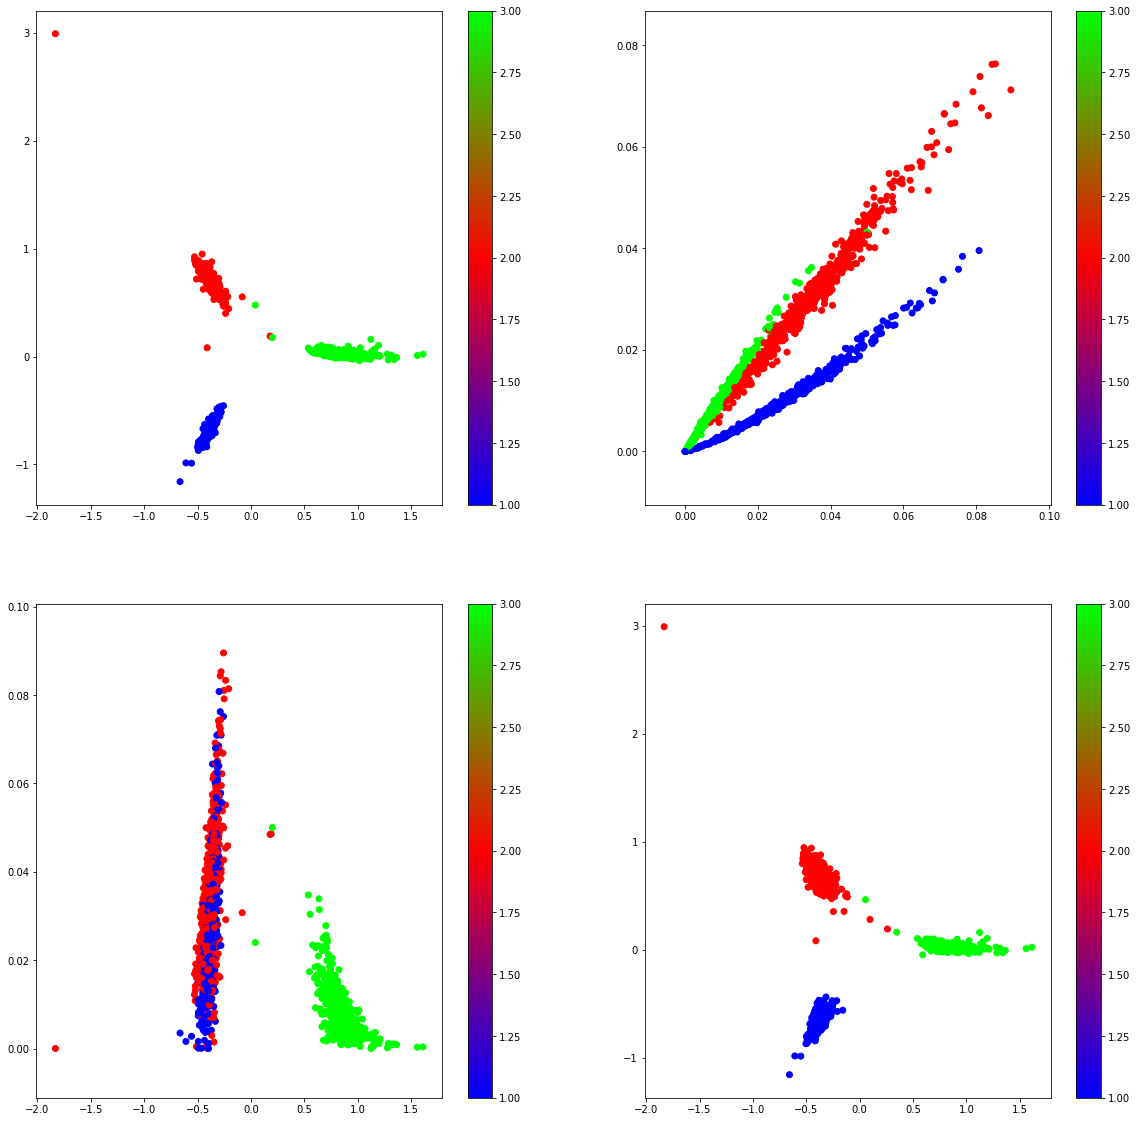

In [11]:
plot_2d_latent_space(model_supervised, onehot_encoder, reuters_data_train_perm, reuters_labels_train_one_hot_perm)

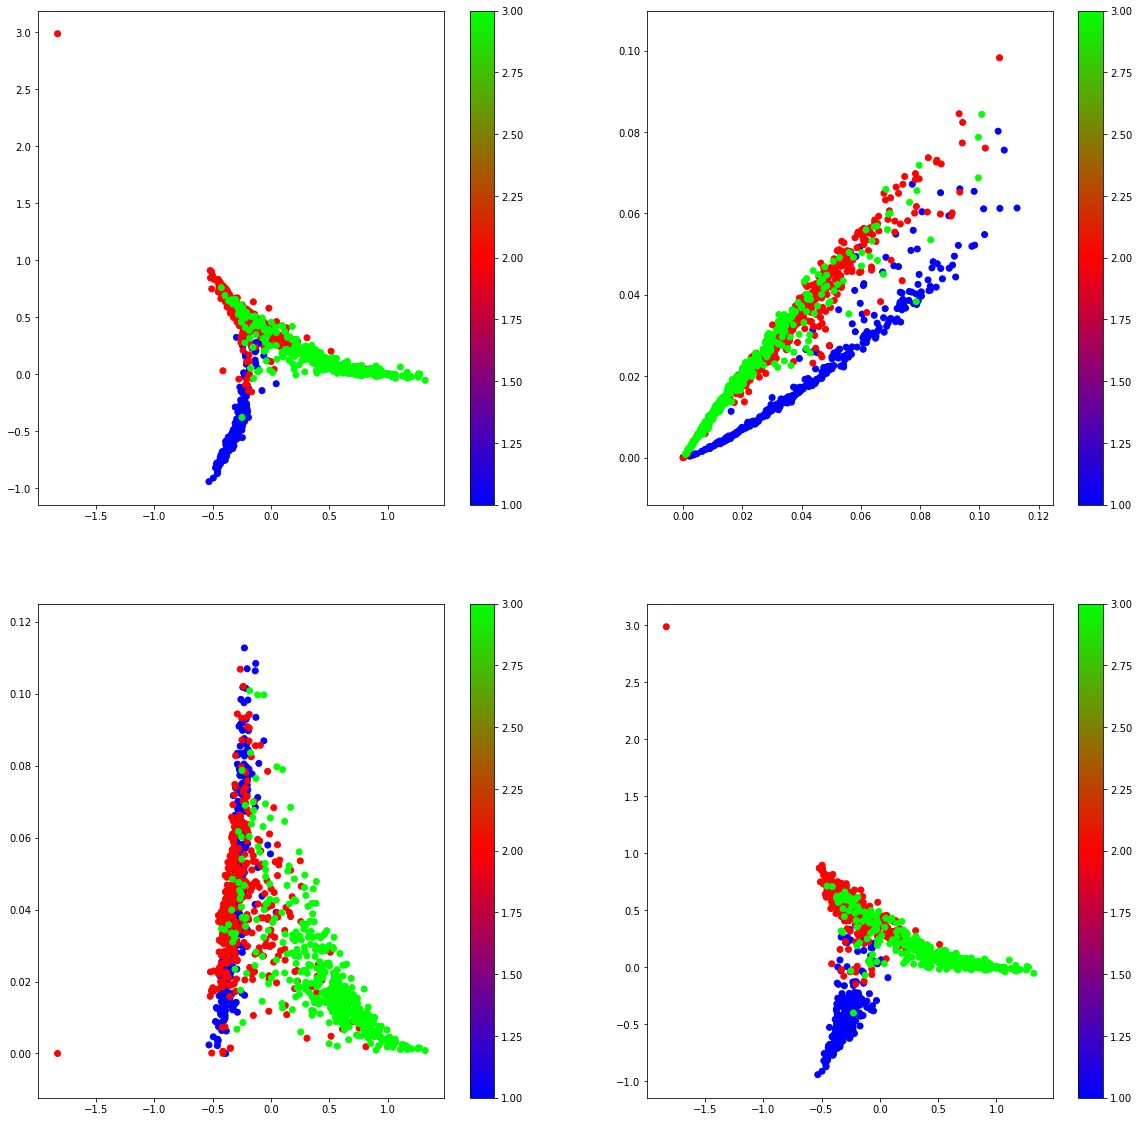

In [12]:
plot_2d_latent_space(model_supervised, onehot_encoder, reuters_data_test, reuters_labels_test_one_hot)

In [13]:
#tf.reset_default_graph()
log_folder = log.get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))

init_cov = np.array([
    [0.07,0.0],
    [0.0,0.007]
], dtype="float64")

betas = np.ones(K)/K

model_supervised_latent_supervised = StochasticNNWithGmm(
    x_dim=reuters_data_train_perm.shape[1],
    y_dim=reuters_labels_train_one_hot_perm.shape[1],
    hidden_dims=[1024, 512, 256, 128, 2],
    log_folder=log_folder,
    alpha=0,
    beta=0,#0.1,
    gamma=1,
    omega=0.0001,
    r=0.8,
    K=3,
    init_cov=init_cov,
    is_latent_supervised=True,
    mixture_weights=betas
)
model_supervised_latent_supervised.fit(
    X_train=reuters_data_train_perm, 
    y_train=reuters_labels_train_one_hot_perm, 
    X_test=reuters_data_test,
    y_test=reuters_labels_test_one_hot,
    epochs=10,
    log_interval=10
)

test_acc = model_supervised_latent_supervised.calculate_accuracy(X=reuters_data_test, y=reuters_labels_test_one_hot)
print("Test accuracy {}".format(test_acc))

Starting autoencoder. Log folder=/tmp/class_vae/deep/01_05_2019/20190501150517
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.6954683065414429
Test accuracy 0.6107078194618225
epoch: 1
Train accuracy 0.9758307933807373
Test accuracy 0.8575317859649658
epoch: 2
Train accuracy 0.9897280931472778
Test accuracy 0.8284936547279358
epoch: 3
Train accuracy 0.9981873035430908
Test accuracy 0.8584392070770264
epoch: 4
Train accuracy 0.998791515827179
Test accuracy 0.8493648171424866
epoch: 5
Train accuracy 0.998791515827179
Test accuracy 0.8430126905441284
epoch: 6
Train accuracy 0.9993957877159119
Test accuracy 0.8638838529586792
epoch: 7
Train accuracy 0.9993957877159119
Test accuracy 0.8529945611953735
epoch: 8
Train accuracy 0.9993957877159119
Test accuracy 0.8584392070770264
epoch: 9
Train accuracy 0.9993957877159119
Test accuracy 0.8638838529586792
Test accuracy 0.8602541089057922


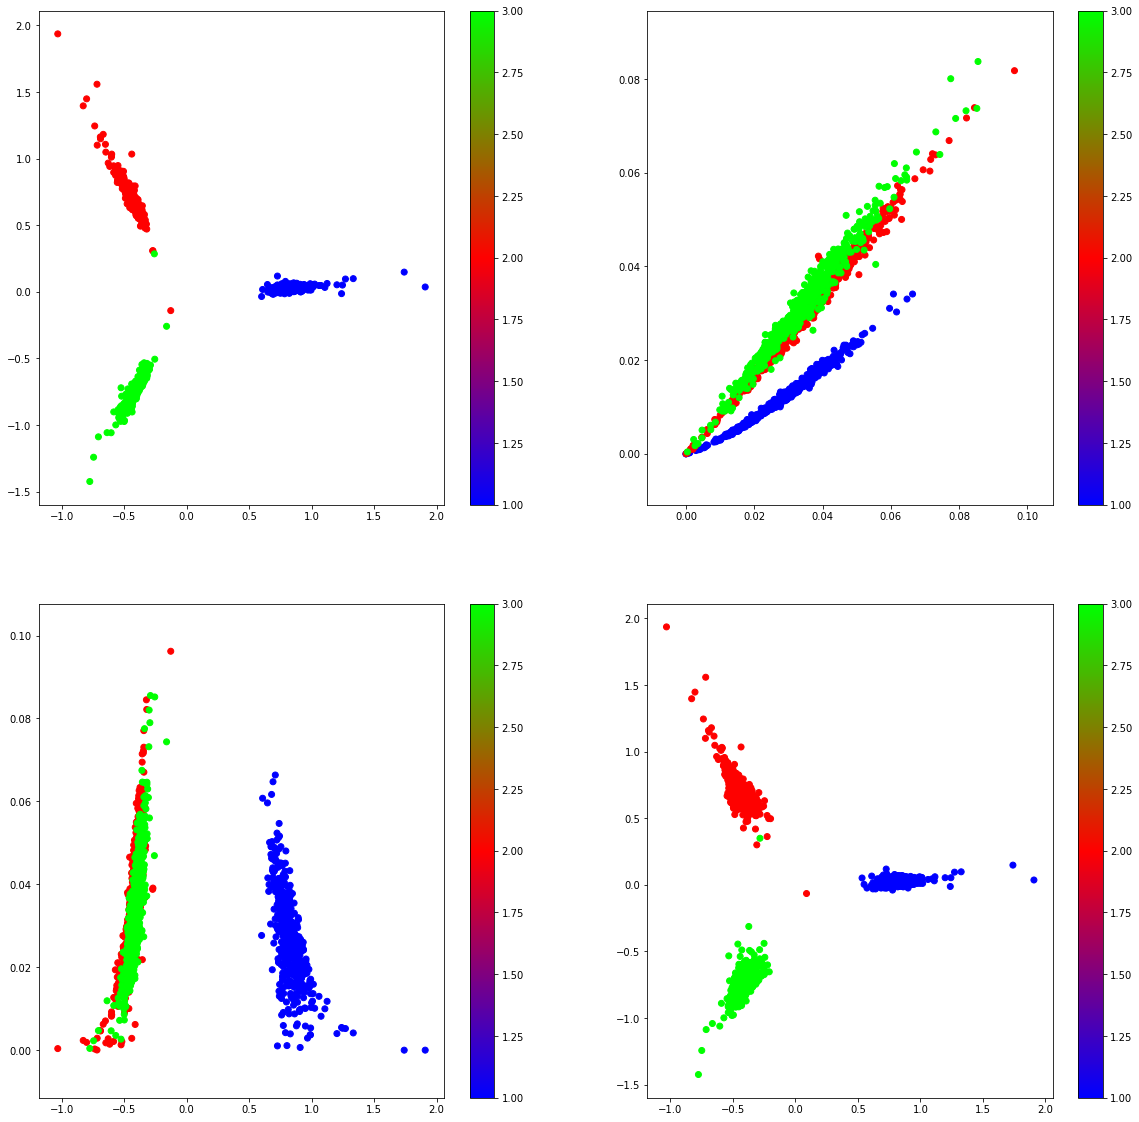

In [31]:
plot_2d_latent_space(model_supervised_latent_supervised, onehot_encoder, reuters_data_train, reuters_labels_train_one_hot)


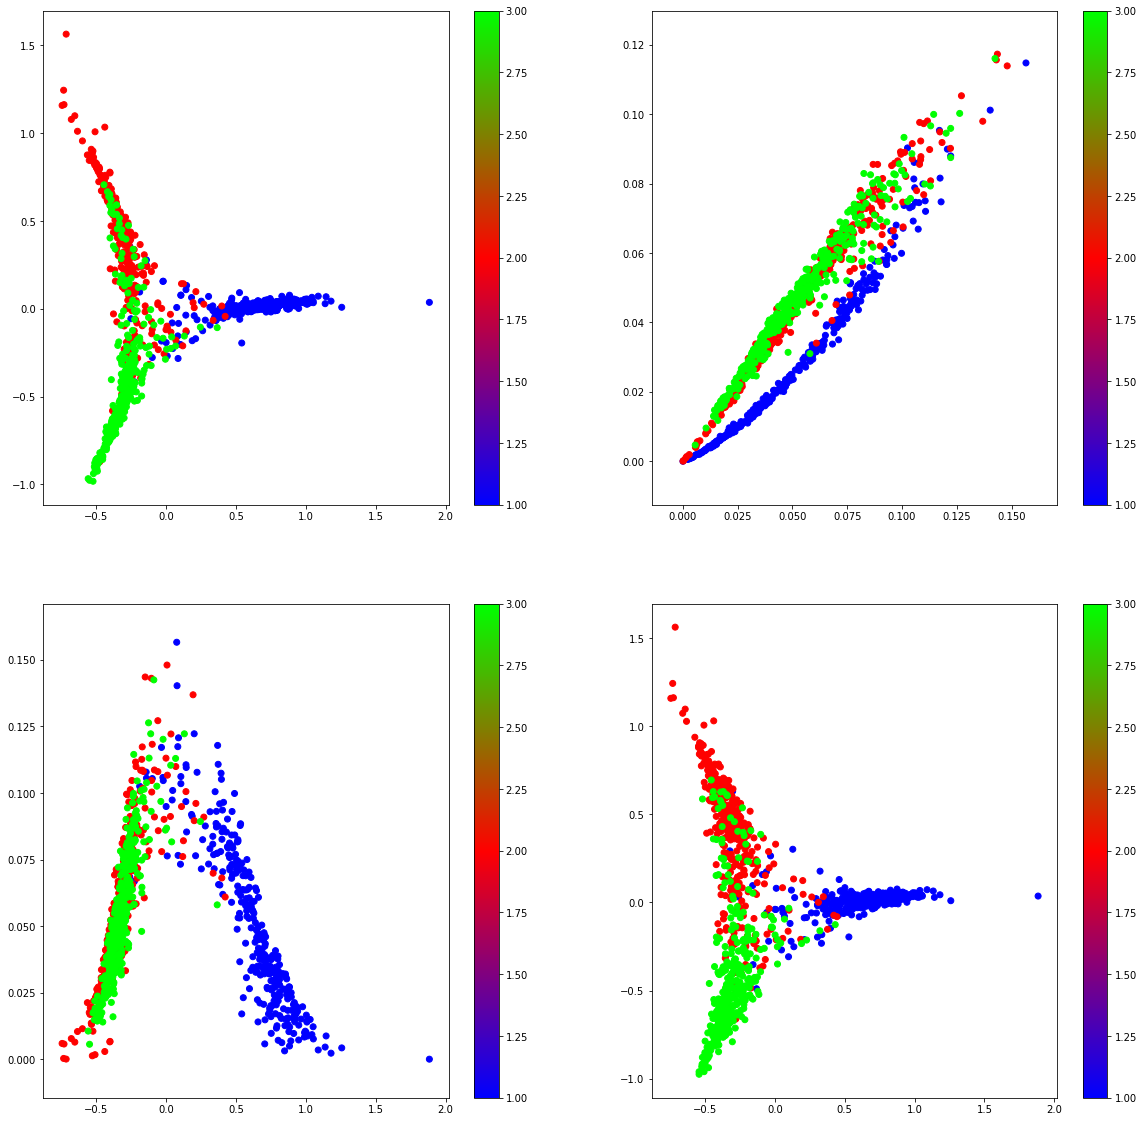

In [32]:
plot_2d_latent_space(model_supervised_latent_supervised, onehot_encoder, reuters_data_test, reuters_labels_test_one_hot)


In [14]:
test_prediction = model_supervised_latent_supervised.encode2(reuters_data_test)

In [16]:
test_prediction[0].shape

(1102, 2)